Для первой задачи мы используем данные [Jester Online Joke Recommender System](https://goldberg.berkeley.edu/jester-data/)

**Описание данных**

Файл `train_joke_df.csv` содержит:
- UID - id пользователей
- JID - id шуток, которые 
- Ratin - рейтинг шутки, который проставил пользователь 


Рейтинг имеет значение от -10.00 до 10.00. Могут встречаться значения 99.00, но это обозначает Null (нет рейтинга от пользователя).

Метрика для оценки [RMSE](https://www.codecamp.ru/blog/how-to-interpret-rmse/)

RMSE: `3.99981`



### Import

In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns
import os
import joblib   


np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Загрузка и обработка данных

In [3]:
df = pd.read_csv('/kaggle/input/recsys-in-practice/train_joke_df.csv')

df.head(5)

,UID,JID,Rating
0,18029,6,-1.26
1,3298,64,-4.17
2,3366,58,0.92
3,12735,92,3.69
4,11365,38,-6.60


Преобразуем датафрейм к более удобному виду, теперь каждая строка - 100 оцекок одного пользовотеля

In [4]:
df1 = pd.pivot_table(data=df, values='Rating', index='UID', columns='JID')

In [5]:
df1

JID,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
UID,,,,,,,,,,,,,,,,,,,,,
1,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,NaN,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
2,4.08,-0.29,6.36,4.37,NaN,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,NaN,3.06,NaN,-4.32,NaN
3,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,8.35,NaN,NaN,1.80,NaN,-2.82,6.21,NaN,1.84,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
5,8.50,4.61,-4.17,-5.39,NaN,NaN,7.04,NaN,-0.44,NaN,...,NaN,5.58,4.27,5.19,5.73,1.55,NaN,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,0.44,NaN,NaN,2.33,NaN,6.75,-8.79,-0.53,NaN,NaN,...,8.83,-1.21,9.22,-6.70,NaN,9.03,6.55,8.69,NaN,7.43
24980,NaN,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,NaN,...,-1.17,-5.73,NaN,0.24,9.22,-8.20,NaN,-8.59,9.13,8.45
24981,NaN,NaN,NaN,NaN,-7.77,NaN,NaN,-6.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df1["UID"] = df1.index

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24983 entries, 1 to 24983
Columns: 101 entries, 1 to UID
dtypes: float64(100), int64(1)
memory usage: 19.4 MB


Наши будущие модели: 

100 `Ridge`

100 `CatBoostRegressor` 

# Ridge

Добавим такие фичи, как:

`mean_user_ratin` - Средний рейтинг, который ставит пользовотель

`median_user_ratin` - Медиана рейтингов, которые стаивт пользовотель

`min_user_ratin` - Минимальный рейтинг, который поставил пользователь

`max_user_ratin` - Максимальный рейтинг, который поставил пользователь

`count_user_ratin` - Количество шуток, которое оценил пользовотель

Так же заменим Nan-ы на медиану оценок по данной шутке(что бы избежать влияния выбросов)

На этих фичах (105) обучим `Ridge` регрессию.

Важно отметить, что мы имеем 100 моделей `Ridge`, так как каждая модель обучается на предсказание оценки отдельной шутки(это позволяет сделать настройку более точной)

In [8]:
ridge_RMSE = []
linear_models = {}
for i in range(1,101):
    df2 = df1.dropna(subset=[i])
    X = df2.drop(columns = [i,'UID'], axis=1)
    count = X.isnull().sum(axis=1)
    y = df2[i]
    X = X.fillna(X.median())

    X['mean_user_ratin'] = X.mean(axis = 1)
    X['median_user_ratin'] = X.median(axis = 1)
    X['min_user_ratin'] = X.min(axis = 1)
    X['max_user_ratin'] = X.max(axis = 1)
    X['count_user_ratin'] = 100-count
    X_train, X_test, y_train, y_test = train_test_split( np.array(X), np.array(y), test_size=0.1, random_state=42)
        
    ridge = Ridge(alpha = 0.1)
    ridge.fit(X_train, y_train)
    
    linear_models[f'model_{i}'] = ridge
    
    ridge_pred = ridge.predict(X_test)
    ridge_rms = mean_squared_error(y_test, ridge_pred, squared=False)
    ridge_RMSE.append(ridge_rms)
    if i%10 == 0:
        print(i,"%")

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %


In [9]:
scores_RMSE = np.array(ridge_RMSE).mean()
scores_RMSE

4.015427784211966

Взглянем на среднее качество по шуткам

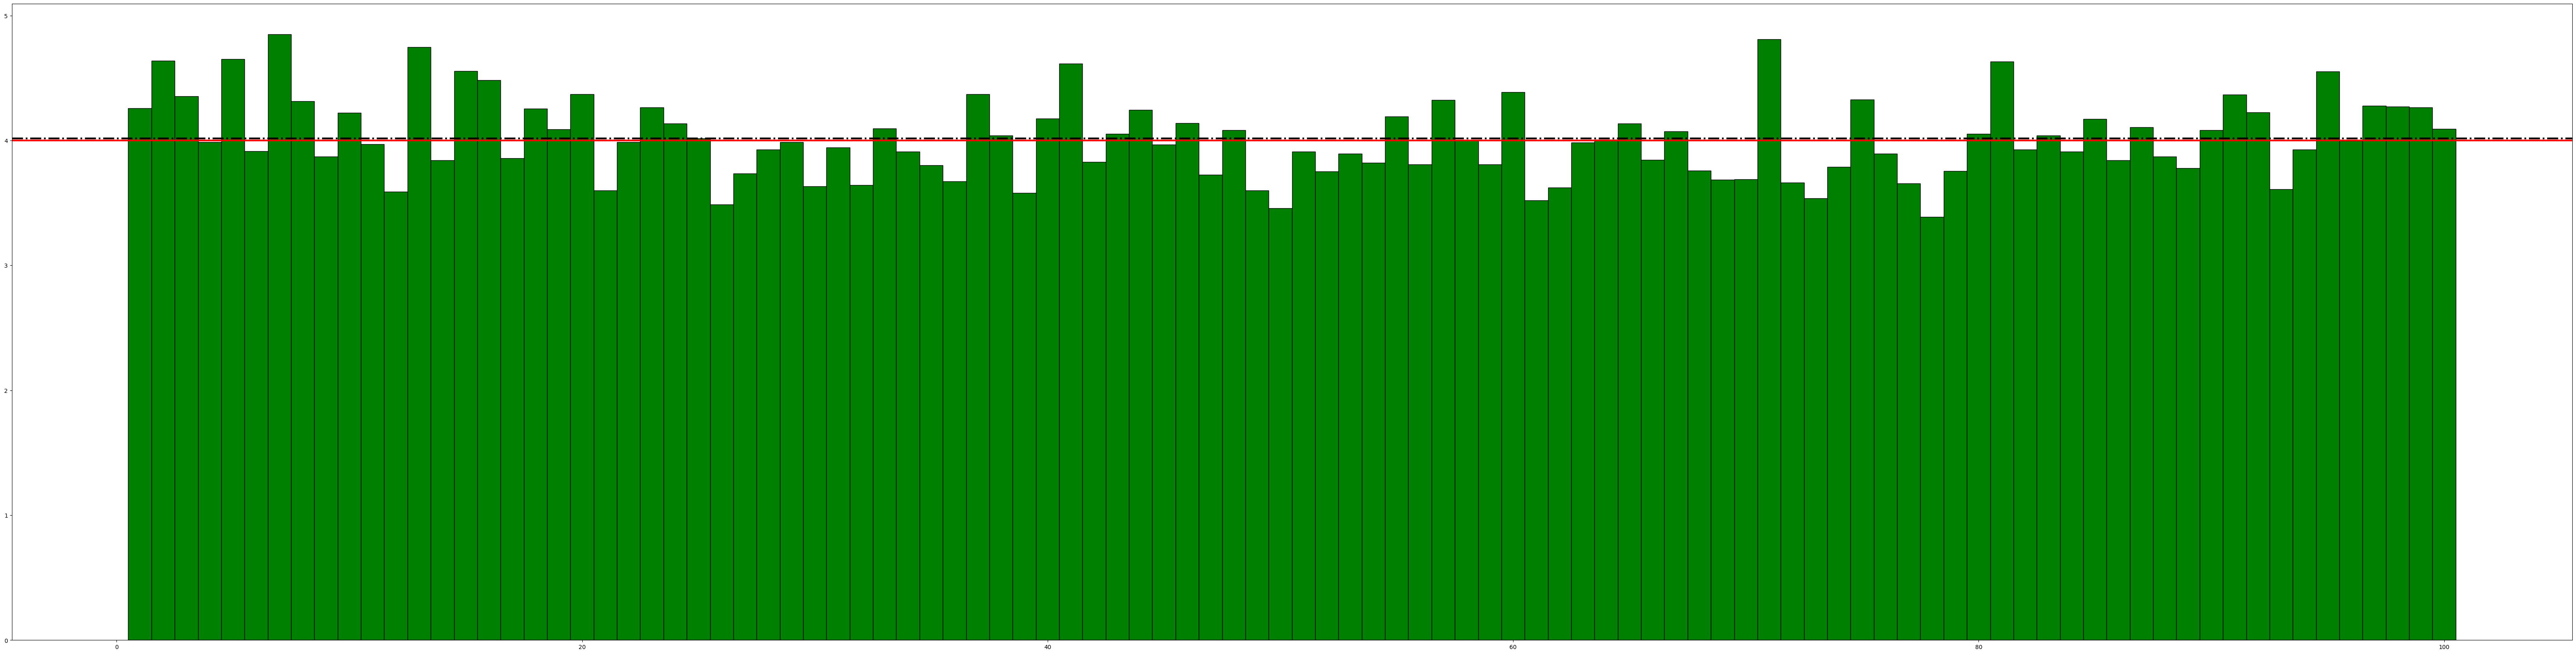

In [10]:
width = 1.0     
plt.figure(figsize=(80, 20))
plt.axhline(y = 4, color = 'r', linestyle = '-', linewidth = 3)
plt.axhline(y = scores_RMSE, color = 'black', linestyle = '-.',linewidth= 3)
plt.bar(np.arange(1,101,1), ridge_RMSE, width, color='g',edgecolor = "black");

In [11]:
os.mkdir("linear_models")
dir = "linear_models"

In [12]:
def save_ridge_models(linear_models,dir):
    for i in range(1,101):
        model = linear_models[f'model_{i}']
        path = dir+'/'+f'model_{i}.pkl'
        joblib.dump(model,path)
    print("Done!")
    
def load_ridge_models(dir):
    linear_models ={}
    for i in range(1,101):
        path = dir+'/'+f'model_{i}.pkl'
        model = joblib.load(path)
        linear_models[f'model_{i}'] = model
    print("Done!")
    return linear_models

In [13]:
save_ridge_models(linear_models,dir)

Done!


In [14]:
linear_models = load_ridge_models(dir)

Done!


## Сatboost

In [15]:
df1

JID,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,UID
UID,,,,,,,,,,,,,,,,,,,,,
1,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN,1
2,4.08,-0.29,6.36,4.37,NaN,-9.66,-0.73,-5.34,8.88,9.22,...,-4.95,-0.29,7.86,-0.19,NaN,3.06,NaN,-4.32,NaN,2
3,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,8.35,NaN,NaN,1.80,NaN,-2.82,6.21,NaN,1.84,...,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN,4
5,8.50,4.61,-4.17,-5.39,NaN,NaN,7.04,NaN,-0.44,NaN,...,5.58,4.27,5.19,5.73,1.55,NaN,6.55,1.80,1.60,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,0.44,NaN,NaN,2.33,NaN,6.75,-8.79,-0.53,NaN,NaN,...,-1.21,9.22,-6.70,NaN,9.03,6.55,8.69,NaN,7.43,24979
24980,NaN,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,NaN,...,-5.73,NaN,0.24,9.22,-8.20,NaN,-8.59,9.13,8.45,24980
24981,NaN,NaN,NaN,NaN,-7.77,NaN,NaN,-6.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24981


Теперь обучим 100 моделей CatBoostRegressor на 99 рейтингах и 7 придуманныхх нами фичах:

`mean_user_ratin` - Средний рейтинг, который ставит пользовотель

`median_user_ratin` - Медиана рейтингов, которые стаивт пользовотель

`min_user_ratin` - Минимальный рейтинг, который поставил пользователь

`max_user_ratin` - Максимальный рейтинг, который поставил пользователь

`count_user_ratin` - Количество шуток, которое оценил пользовотель

`ridge_model_pred` - Рейтинг шутки предсказанный `Ridge`

In [16]:
###### 
RMSE = []
models = {}
for i in range(1,101):
    df2 = df1.dropna(subset=[i])
    X = df2.drop(columns = [i,'UID'], axis=1)
    count = X.isnull().sum(axis=1)
    y = df2[i]
    X = X.fillna(X.median())
    X['mean_user_ratin'] = X.mean(axis = 1)
    X['median_user_ratin'] = X.median(axis = 1)
    X['min_user_ratin'] = X.min(axis = 1)
    X['max_user_ratin'] = X.max(axis = 1)
    X['count_user_ratin'] = 100-count
    predictions = linear_models[f'model_{i}'].predict(np.array(X))
    X['ridge_model_pred'] = predictions
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)
    model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric ='RMSE',
    iterations = 300,
    learning_rate=0.1,
    task_type='GPU',
    use_best_model = True
    )
    model.fit(
      X_train, y_train,
      eval_set=(X_test, y_test),
      verbose=100
    );
    models[f'model_{i}'] = model
    pred = model.predict(np.array(X_test))
    rms = mean_squared_error(y_test, pred, squared=False)
    RMSE.append(rms)
    if i%10 == 0:
        print(i,"%")

0:	learn: 5.0049813	test: 5.0611150	best: 5.0611150 (0)	total: 43.1ms	remaining: 12.9s
100:	learn: 3.8836897	test: 4.2841817	best: 4.2841817 (100)	total: 3.36s	remaining: 6.62s
200:	learn: 3.5820075	test: 4.2881941	best: 4.2831127 (116)	total: 5.95s	remaining: 2.93s
299:	learn: 3.3161873	test: 4.3045416	best: 4.2831127 (116)	total: 9.47s	remaining: 0us
bestTest = 4.283112706
bestIteration = 116
Shrink model to first 117 iterations.
0:	learn: 5.4489115	test: 5.3669158	best: 5.3669158 (0)	total: 19.6ms	remaining: 5.86s
100:	learn: 4.2252525	test: 4.5644983	best: 4.5625009 (88)	total: 2.56s	remaining: 5.04s
200:	learn: 3.9184415	test: 4.5830574	best: 4.5625009 (88)	total: 5.95s	remaining: 2.93s
299:	learn: 3.6445306	test: 4.5814291	best: 4.5625009 (88)	total: 9.15s	remaining: 0us
bestTest = 4.562500941
bestIteration = 88
Shrink model to first 89 iterations.
0:	learn: 5.2203306	test: 5.1818364	best: 5.1818364 (0)	total: 19.3ms	remaining: 5.77s
100:	learn: 4.0021692	test: 4.3134934	best: 4.

In [17]:
reg = models['model_71']

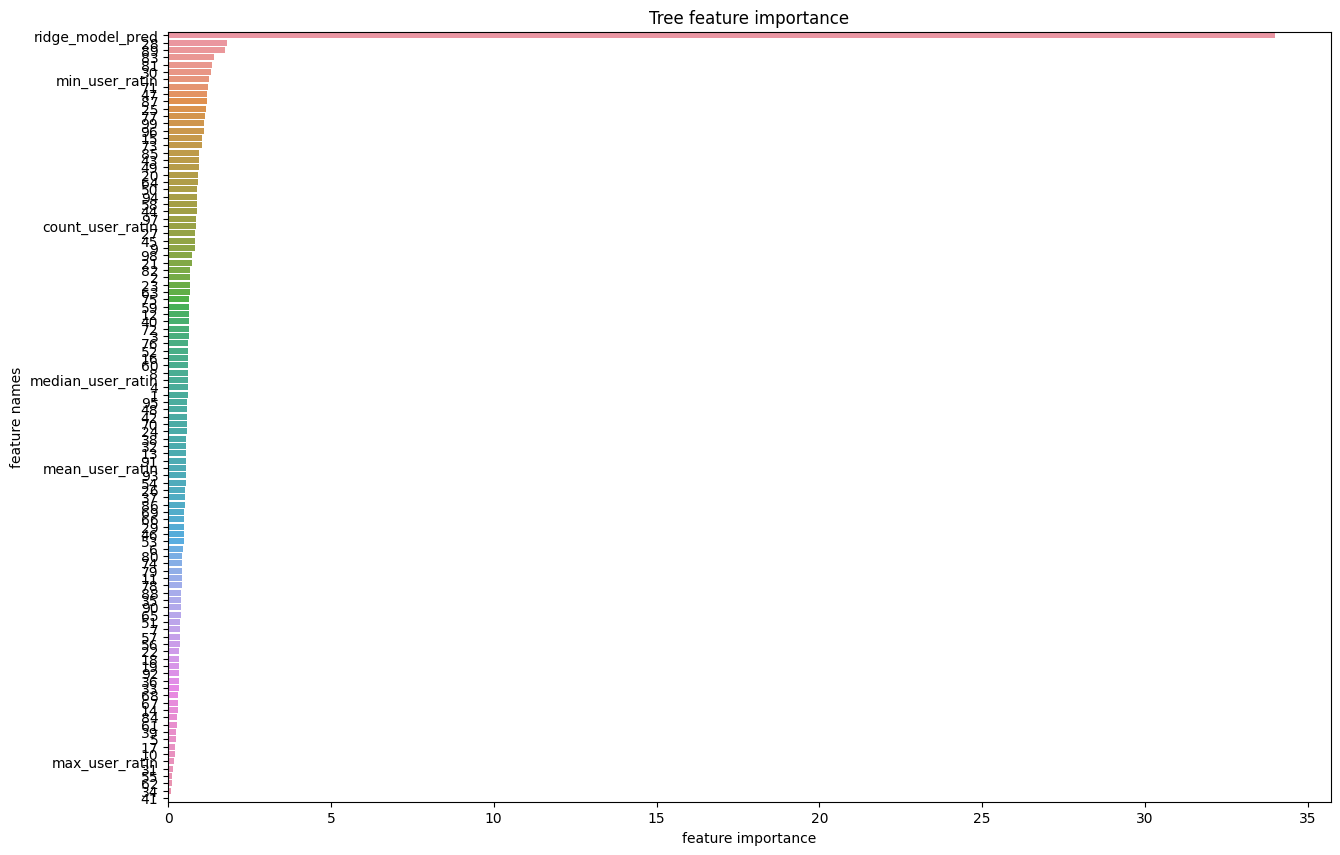

In [18]:
feature_importance = np.array(reg.feature_importances_)
feature_names = np.array(X_train.columns)
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
plt.figure(figsize=(15,10))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
plt.title("Tree " + 'feature importance')
plt.xlabel('feature importance')
plt.ylabel('feature names');

Видим, что наши фичи не такие уж и бесполезные 

In [19]:
np.array(RMSE).mean()

3.9767355167108893

<BarContainer object of 100 artists>

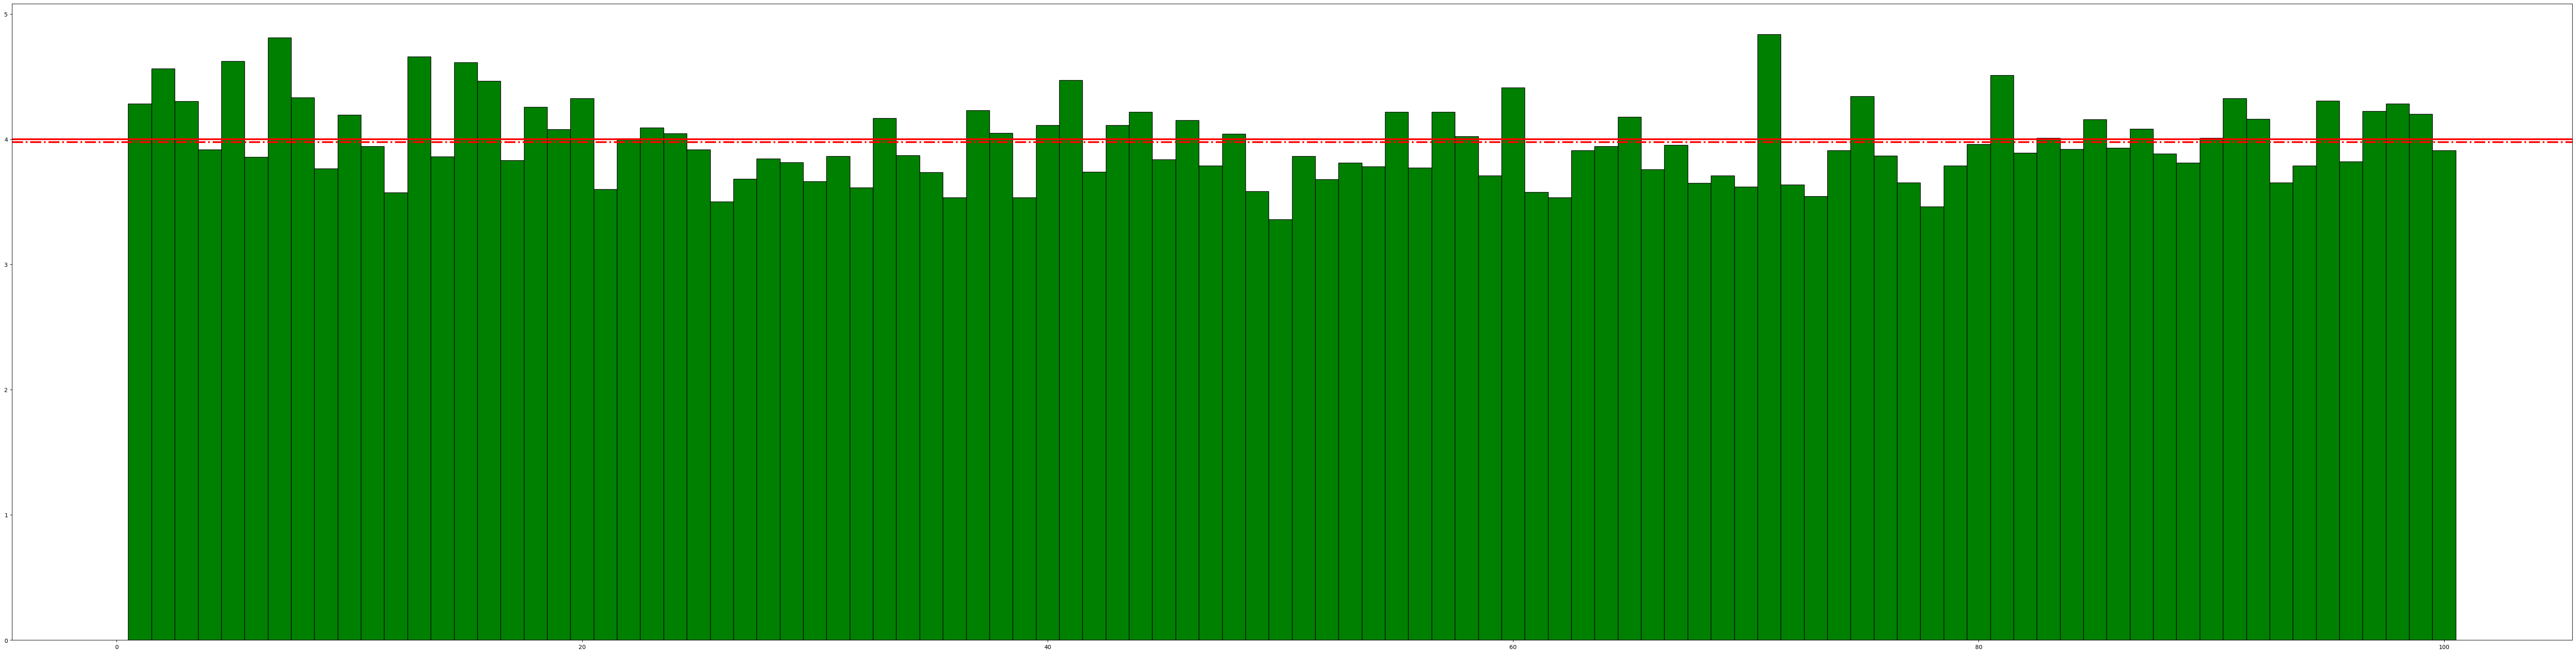

In [20]:
width = 1.0 
plt.figure(figsize=(80, 20))
plt.axhline(y = 4, color = 'r', linestyle = '-',linewidth = 3)
plt.axhline(y = np.array(RMSE).mean(), color = 'r', linestyle = '-.',linewidth = 3)
plt.bar(np.arange(1,101,1), RMSE, width, color='g',edgecolor = "black")

In [21]:
os.mkdir("models")
dir = "models"

In [22]:
def save_catboost_models(models,dir):
    for i in range(1,101):
        model = models[f'model_{i}']
        path = dir+'/'+f'model_{i}.cbm'
        model.save_model(path)
    print("Done!")
    
def load_catboost_models(dir):
    models ={}
    for i in range(1,101):
        path = dir+'/'+f'model_{i}.cbm'
        #model = joblib.load(path)
        model = CatBoostRegressor()      # parameters not required.
        model.load_model(path)
        models[f'model_{i}'] = model
    print("Done!")
    return models

In [23]:
save_catboost_models(models,dir)
models = load_catboost_models(dir)

Done!
Done!


In [24]:
df_f = df1.fillna(df1.median())

In [25]:
count = df1.isnull().sum(axis=1)

In [26]:
df_f

JID,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,UID
UID,,,,,,,,,,,,,,,,,,,,,
1,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,1.80,3.16,1.75,1.75,2.09,-5.63,1.41,0.39,2.14,1
2,4.08,-0.29,6.36,4.37,1.17,-9.66,-0.73,-5.34,8.88,9.22,...,-4.95,-0.29,7.86,-0.19,2.09,3.06,1.41,-4.32,2.14,2
3,1.60,0.83,0.83,-1.50,9.03,9.27,9.03,9.27,-0.19,1.94,...,1.80,3.16,1.75,1.75,2.09,2.48,1.41,0.39,2.14,3
4,1.60,8.35,0.83,-1.50,1.80,2.23,-2.82,6.21,-0.19,1.84,...,1.80,3.16,0.53,1.75,2.09,2.48,1.41,0.39,2.14,4
5,8.50,4.61,-4.17,-5.39,1.17,2.23,7.04,-0.29,-0.44,1.94,...,5.58,4.27,5.19,5.73,1.55,2.48,6.55,1.80,1.60,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,0.44,0.83,0.83,2.33,1.17,6.75,-8.79,-0.53,-0.19,1.94,...,-1.21,9.22,-6.70,1.75,9.03,6.55,8.69,0.39,7.43,24979
24980,1.60,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,1.94,...,-5.73,3.16,0.24,9.22,-8.20,2.48,-8.59,9.13,8.45,24980
24981,1.60,0.83,0.83,-1.50,-7.77,2.23,-0.10,-6.75,-0.19,1.94,...,1.80,3.16,1.75,1.75,2.09,2.48,1.41,0.39,2.14,24981


In [27]:
df_f['mean_user_ratin'] = df_f.drop(columns='UID').mean(axis = 1)
df_f['median_user_ratin'] = df_f.median(axis = 1)
df_f['min_user_ratin'] = df_f.drop(columns='UID').min(axis = 1)
df_f['max_user_ratin'] = df_f.drop(columns='UID').max(axis = 1)
df_f['count_user_ratin'] = 100-count

/tmp/ipykernel_30/3232824198.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_f['mean_user_ratin'] = df_f.drop(columns='UID').mean(axis = 1)


In [28]:
df_f

JID,1,2,3,4,5,6,7,8,9,10,...,97,98,99,100,UID,mean_user_ratin,median_user_ratin,min_user_ratin,max_user_ratin,count_user_ratin
UID,,,,,,,,,,,,,,,,,,,,,
1,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,-5.63,1.41,0.39,2.14,1,-1.48690,0.68000,-9.85,9.13,62
2,4.08,-0.29,6.36,4.37,1.17,-9.66,-0.73,-5.34,8.88,9.22,...,3.06,1.41,-4.32,2.14,2,2.39240,2.26620,-9.66,9.22,84
3,1.60,0.83,0.83,-1.50,9.03,9.27,9.03,9.27,-0.19,1.94,...,2.48,1.41,0.39,2.14,3,3.47990,2.48000,-7.86,9.37,41
4,1.60,8.35,0.83,-1.50,1.80,2.23,-2.82,6.21,-0.19,1.84,...,2.48,1.41,0.39,2.14,4,1.56320,1.55000,-8.30,8.35,39
5,8.50,4.61,-4.17,-5.39,1.17,2.23,7.04,-0.29,-0.44,1.94,...,2.48,6.55,1.80,1.60,5,2.75675,3.11000,-9.66,8.93,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,0.44,0.83,0.83,2.33,1.17,6.75,-8.79,-0.53,-0.19,1.94,...,6.55,8.69,0.39,7.43,24979,1.88885,2.20500,-9.95,9.27,84
24980,1.60,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,1.94,...,2.48,-8.59,9.13,8.45,24980,1.84910,1.72455,-9.17,9.22,76
24981,1.60,0.83,0.83,-1.50,-7.77,2.23,-0.10,-6.75,-0.19,1.94,...,2.48,1.41,0.39,2.14,24981,0.27340,0.83000,-7.86,7.38,26


### Для отправки на тестирование

In [29]:
test = pd.read_csv('/kaggle/input/recsys-in-practice/test_joke_df_nofactrating.csv', index_col=0)
test.head(5)

,UID,JID
InteractionID,,
0,11228,39
1,21724,85
2,16782,56
3,12105,42
4,14427,2


Само предсказание на test-е (`!!!` ДОЛГО `!!!`)

In [30]:
ANS = []
for i, row in test.iterrows():
    X_teat_f = df_f[df_f['UID'] == row['UID']].drop(columns=[row["JID"],'UID'])
    X_teat_f['ridge_model_pred'] = linear_models[f'model_{row["JID"]}'].predict(np.array(X_teat_f).reshape(1, -1))
    ans = models[f'model_{row["JID"]}'].predict(X_teat_f)
    if len(ANS)%1000 == 0:
        print(len(ANS)/len(test))
    ANS.append(ans[0])

0.0
0.0027617366905004544
0.005523473381000909
0.008285210071501363
0.011046946762001818
0.013808683452502272
0.016570420143002727
0.01933215683350318
0.022093893524003635
0.024855630214504088
0.027617366905004544
0.030379103595504997
0.03314084028600545
0.03590257697650591
0.03866431366700636
0.041426050357506815
0.04418778704800727
0.04694952373850772
0.049711260429008176
0.05247299711950863
0.05523473381000909
0.05799647050050954
0.060758207191009994
0.06351994388151044
0.0662816805720109
0.06904341726251136
0.07180515395301182
0.07456689064351227
0.07732862733401272
0.08009036402451318
0.08285210071501363
0.08561383740551408
0.08837557409601454
0.09113731078651499
0.09389904747701544
0.0966607841675159
0.09942252085801635
0.10218425754851682
0.10494599423901727
0.10770773092951771
0.11046946762001818
0.11323120431051863
0.11599294100101908
0.11875467769151954
0.12151641438201999
0.12427815107252044
0.1270398877630209
0.12980162445352136
0.1325633611440218
0.13532509783452226
0.1380

In [31]:
ANS

[1.9055553340094775,
 -7.383681944338605,
 -0.14033408639443223,
 7.189803729162122,
 7.0595830380989355,
 -3.2743274157401174,
 0.7533665058908809,
 -5.684523001470552,
 -6.436826853663661,
 -2.624629229059792,
 -0.2445176560577238,
 2.060275621304754,
 -0.7488417090407893,
 -4.077599128548172,
 2.995995831559412,
 -2.1326617829545285,
 0.3393306543075596,
 -0.017026996243657777,
 -0.6474410923401592,
 6.133464530783385,
 2.0566045251034666,
 -0.8467421317545814,
 4.2966067808629305,
 -8.479279909224715,
 3.849216993083246,
 2.5240565048443386,
 1.8484937527678085,
 -1.0950574327725917,
 1.3128504264968797,
 7.385678530234145,
 5.8900094582058955,
 -1.843496729619801,
 0.16683119772642385,
 0.5805502156290459,
 5.984966414762312,
 4.638367283434491,
 2.8482681802706793,
 6.294438976445235,
 0.9531767300359206,
 2.9136399907729356,
 4.114235511588049,
 -1.9059356662910432,
 -5.339305407251231,
 -1.4606529967859387,
 5.369942024248303,
 -1.2865755844395608,
 3.0942610390611662,
 2.53552

In [32]:
test['Rating'] = ANS

In [33]:
test = test.drop(['UID', 'JID'], axis=1) 

In [34]:
test.to_csv('submission.csv')

# Для финального предсказания

In [39]:
# Данные для моделей
df = pd.read_csv(f'/kaggle/input/recsys-in-practice/train_joke_df.csv')

test = pd.DataFrame({'UID': [7]})#pd.read_csv('input.csv')

arr = test['UID']

# Предсказание
BEST = []
TOP_10 = []
for uid in arr:
    rating = {}
    for jid in range(1, 101):
        if np.sum((df['UID'] == uid) & (df['JID'] == jid)):
            rating_jid = np.array(df[(df['UID'] == uid) & (df['JID'] == jid)]['Rating'])[0]
        else:
            X_test_f = df_f[df_f['UID'] == jid].drop(columns=[jid, 'UID'])
            X_test_f['ridge_model_pred'] = linear_models[f'model_{jid}'].predict(np.array(X_test_f))
            rating_jid = models[f'model_{jid}'].predict(X_test_f)[0]
        rating[f'{jid}'] = rating_jid
    sorted_rating = sorted(rating.items(), key=lambda kv: -kv[1])
    best = {sorted_rating[0][0]: sorted_rating[0][1]}
    top_10 = [i[0] for i in sorted_rating[1:10]]
    BEST.append(best)
    TOP_10.append(top_10)

ans = pd.DataFrame({'best': BEST, 'top_10': TOP_10})
ans

,best,top_10
0,{'65': 8.93},"[8, 5, 53, 66, 56, 35, 7, 12, 69]"
